In [22]:
# Ensure time series tools and datetime are available in this session
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.stattools import adfuller
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.stattools import adfuller

# Normalize datetime import so `datetime.now()` works
try:
    from datetime import datetime, timedelta
except Exception as e:
    import datetime as _dt_module
    datetime = _dt_module.datetime
    timedelta = _dt_module.timedelta

print("seasonal_decompose, adfuller, and datetime ready")


seasonal_decompose, adfuller, and datetime ready


# 🏠 Real Estate Demand Prediction - Advanced AutoGluon Solution

## Competition Overview
This notebook tackles the Real Estate Demand Prediction challenge focused on China's real estate market. Our goal is to forecast monthly residential demand using historical transaction data, market conditions, and other relevant features.

### Key Competition Insights:
- Target: `amount_new_house_transaction` (in 10,000 Chinese Yuan)
- Evaluation: Custom two-stage MAPE-based metric
- Data: Time series data from 2019-2024 across multiple sectors



In [18]:
import datetime

In [ ]:
# Install required packages
!pip install autogluon pandas numpy matplotlib seaborn plotly scikit-learn lightgbm xgboost 
!pip install optuna shap boruta_py feature-engine tsfresh statsmodels
!pip install autogluon.timeseries --upgrade

import warnings
warnings.filterwarnings('ignore')
import datetime

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# AutoGluon
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.tabular import TabularPredictor
from autogluon.common import space

# ML libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Feature engineering
from feature_engine.creation import CyclicalFeatures
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

# Statistical analysis
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Utilities
import os
import gc
from datetime import datetime, timedelta
import joblib

# Configuration
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set random seed for reproducibility
np.random.seed(42)

print("🚀 All libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🤖 AutoGluon available: True")

  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
  Using cached seqeval-1.2.2-py3-none-any.whl
  Using cached timm-1.0.3-py3-none-any.whl.metadata (43 kB)
  Using cached nlpaug-1.1.11-py3-none-any.whl.metadata (14 kB)
  Using cached openmim-0.3.9-py2.py3-none-any.whl.metadata (16 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached window_ops-0.0.15-py3-none-any.whl.metadata (6.8 kB)
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached model_index-0.1.11-py3-none-any.whl.metadata (3.9 kB)
  Using cached opendatalab-0.0.10-py3-none-any.whl.metadata (6.4 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 16.1 MB/s eta 0:00:00
Using cached nlpaug-1.1.11-py3-none-any.whl (410 kB)
Using cached openmim-0.3.9-py2.py3-none-any.whl (52 kB)
Using cached timm-1.0.3-py3-none-any.wh

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
astro-pi-replay 1.2.1 requires numpy==1.24.3; sys_platform != "emscripten" and python_version < "3.12", but you have numpy 1.26.4 which is incompatible.
astro-pi-replay 1.2.1 requires pandas==2.0.3; sys_platform != "emscripten" and python_version < "3.12", but you have pandas 2.2.0 which is incompatible.
astro-pi-replay 1.2.1 requires Pillow==10.0.0; sys_platform != "emscripten", but you have pillow 10.2.0 which is incompatible.
mambular 1.5.0 requires setuptools<76.0.0,>=75.3.0, but you have setuptools 79.0.0 which is incompatible.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 5.29.4 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\bonit\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFo

ERROR: Could not find a version that satisfies the requirement boruta_py (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\bonit\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for boruta_py

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\bonit\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'feature_engine'

## 📊 Data Loading and Initial Exploration

Let's load all the datasets and understand the structure of our time series data.

In [2]:
# Define data paths
data_path = "./"
train_path = "./train/"

# Load all datasets
datasets = {}
file_names = [
    'new_house_transactions.csv',
    'pre_owned_house_transactions.csv', 
    'land_transactions.csv',
    'new_house_transactions_nearby_sectors.csv',
    'pre_owned_house_transactions_nearby_sectors.csv',
    'land_transactions_nearby_sectors.csv',
    'sector_POI.csv',
    'city_search_index.csv',
    'city_indexes.csv'
]

print("📁 Loading datasets...")
for file_name in file_names:
    try:
        df = pd.read_csv(train_path + file_name)
        datasets[file_name.replace('.csv', '')] = df
        print(f"✅ {file_name}: {df.shape[0]:,} rows, {df.shape[1]} columns")
    except Exception as e:
        print(f"❌ Error loading {file_name}: {e}")

# Load test and sample submission
test_df = pd.read_csv(data_path + 'test.csv')
sample_submission = pd.read_csv(data_path + 'sample_submission.csv')

print(f"\n🎯 Test set: {test_df.shape[0]:,} rows")
print(f"📋 Sample submission: {sample_submission.shape[0]:,} rows")

# Display basic info about target dataset
target_df = datasets['new_house_transactions']
print(f"\n🎯 Target dataset shape: {target_df.shape}")
print(f"📅 Date range: {target_df['month'].min()} to {target_df['month'].max()}")
print(f"🏘️ Number of sectors: {target_df['sector'].nunique()}")
print(f"📊 Target statistics:")
print(target_df['amount_new_house_transactions'].describe())

📁 Loading datasets...
✅ new_house_transactions.csv: 5,433 rows, 11 columns
✅ pre_owned_house_transactions.csv: 5,360 rows, 6 columns
✅ land_transactions.csv: 5,896 rows, 6 columns
✅ new_house_transactions_nearby_sectors.csv: 5,360 rows, 11 columns
✅ pre_owned_house_transactions_nearby_sectors.csv: 5,427 rows, 6 columns
✅ land_transactions_nearby_sectors.csv: 5,025 rows, 6 columns
✅ sector_POI.csv: 86 rows, 142 columns
✅ city_search_index.csv: 4,020 rows, 4 columns
✅ city_indexes.csv: 7 rows, 74 columns

🎯 Test set: 1,152 rows
📋 Sample submission: 1,152 rows

🎯 Target dataset shape: (5433, 11)
📅 Date range: 2019-Apr to 2024-May
🏘️ Number of sectors: 95
📊 Target statistics:
count      5433.000000
mean      32587.559558
std       49047.627905
min          50.950000
25%        5200.170000
50%       16040.320000
75%       38499.900000
max      606407.640000
Name: amount_new_house_transactions, dtype: float64


In [3]:
# Comprehensive data exploration
def explore_dataset(df, name):
    print(f"\n{'='*60}")
    print(f"📋 Dataset: {name}")
    print(f"{'='*60}")
    print(f"Shape: {df.shape}")
    print(f"\nColumn types:")
    print(df.dtypes.value_counts())
    print(f"\nMissing values:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        missing_pct = (missing / len(df) * 100).round(2)
        missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
        print(missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False))
    else:
        print("✅ No missing values")
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicates}")
    
    return df

# Explore key datasets
for key in ['new_house_transactions', 'sector_POI', 'city_indexes']:
    if key in datasets:
        datasets[key] = explore_dataset(datasets[key], key)


📋 Dataset: new_house_transactions
Shape: (5433, 11)

Column types:
float64    5
int64      4
object     2
Name: count, dtype: int64

Missing values:
                                   Missing  Percentage
num_new_house_available_for_sale        14        0.26
area_new_house_available_for_sale       14        0.26
period_new_house_sell_through           14        0.26

Duplicate rows: 0

📋 Dataset: sector_POI
Shape: (86, 142)

Column types:
int64      73
float64    68
object      1
Name: count, dtype: int64

Missing values:
                                   Missing  Percentage
surrounding_housing_average_price        4        4.65
surrounding_shop_average_rent            3        3.49

Duplicate rows: 0

📋 Dataset: city_indexes
Shape: (7, 74)

Column types:
float64    60
int64      14
Name: count, dtype: int64

Missing values:
                                                  Missing  Percentage
total_fixed_asset_investment_10k                        7      100.00
total_fixed_assets_10

## 🔍 Comprehensive Exploratory Data Analysis (EDA)

Now let's perform deep EDA with advanced visualizations to understand patterns, trends, and relationships in the data.

In [7]:
# Prepare target data for time series analysis
target_df = datasets['new_house_transactions'].copy()
target_df['month'] = pd.to_datetime(target_df['month'], format='%Y-%b')
target_df = target_df.sort_values(['month', 'sector'])

# Create comprehensive time series plots
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=[
        'Total Transaction Amount Over Time',
        'Number of Transactions Over Time', 
        'Average Price per Square Meter',
        'Transaction Volume Distribution by Sector',
        'Seasonal Decomposition (Sample Sector)',
        'Monthly Growth Rates'
    ],
    specs=[[{"secondary_y": True}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]],
    vertical_spacing=0.12
)

# 1. Total transaction amount over time
monthly_total = target_df.groupby('month')['amount_new_house_transactions'].agg(['sum', 'mean', 'count']).reset_index()
fig.add_trace(
    go.Scatter(x=monthly_total['month'], y=monthly_total['sum'], 
               name='Total Amount', line=dict(color='blue', width=2)),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=monthly_total['month'], y=monthly_total['mean'], 
               name='Average Amount', line=dict(color='red', width=2)),
    row=1, col=1, secondary_y=True
)

# 2. Number of transactions over time
monthly_count = target_df.groupby('month')['num_new_house_transactions'].sum().reset_index()
fig.add_trace(
    go.Scatter(x=monthly_count['month'], y=monthly_count['num_new_house_transactions'],
               name='Total Transactions', line=dict(color='green', width=2)),
    row=1, col=2
)

# 3. Average price trends
price_data = target_df.groupby('month')['price_new_house_transactions'].agg(['mean', 'std']).reset_index()
fig.add_trace(
    go.Scatter(x=price_data['month'], y=price_data['mean'],
               name='Avg Price/sqm', line=dict(color='purple', width=2)),
    row=2, col=1
)

# 4. Sector distribution
sector_totals = target_df.groupby('sector')['amount_new_house_transactions'].sum().sort_values(ascending=True)
fig.add_trace(
    go.Bar(x=sector_totals.values, y=sector_totals.index, orientation='h',
           name='Total by Sector', marker_color='orange'),
    row=2, col=2
)

# 5. Sample seasonal decomposition for sector 1
sector_1_data = target_df[target_df['sector'] == 'sector 1'].set_index('month')['amount_new_house_transactions'].resample('M').sum()
if len(sector_1_data) > 24:  # Need enough data for seasonal decomposition
    decomposition = seasonal_decompose(sector_1_data, model='additive', period=12)
    fig.add_trace(
        go.Scatter(x=sector_1_data.index, y=decomposition.trend,
                   name='Trend (Sector 1)', line=dict(color='darkblue')),
        row=3, col=1
    )
    fig.add_trace(
        go.Scatter(x=sector_1_data.index, y=decomposition.seasonal,
                   name='Seasonal (Sector 1)', line=dict(color='darkred')),
        row=3, col=1
    )

# 6. Growth rates
monthly_total['growth_rate'] = monthly_total['sum'].pct_change() * 100
fig.add_trace(
    go.Bar(x=monthly_total['month'], y=monthly_total['growth_rate'],
           name='Monthly Growth %', marker_color='teal'),
    row=3, col=2
)

fig.update_layout(
    height=1200, 
    title_text="🏠 Real Estate Market - Comprehensive Time Series Analysis",
    title_x=0.5,
    showlegend=True
)

fig.show()

# Print key insights
print("\n📊 KEY INSIGHTS FROM EDA:")
print("="*50)
print(f"📈 Peak transaction month: {monthly_total.loc[monthly_total['sum'].idxmax(), 'month'].strftime('%Y-%m')}")
print(f"📉 Lowest transaction month: {monthly_total.loc[monthly_total['sum'].idxmin(), 'month'].strftime('%Y-%m')}")
print(f"🏆 Most active sector: {sector_totals.index[-1]}")
print(f"💰 Highest average price sector: {target_df.groupby('sector')['price_new_house_transactions'].mean().idxmax()}")
print(f"📊 Average monthly growth rate: {monthly_total['growth_rate'].mean():.2f}%")
print(f"📈 Growth rate volatility (std): {monthly_total['growth_rate'].std():.2f}%")


📊 KEY INSIGHTS FROM EDA:
📈 Peak transaction month: 2020-12
📉 Lowest transaction month: 2020-02
🏆 Most active sector: sector 55
💰 Highest average price sector: sector 32
📊 Average monthly growth rate: 10.33%
📈 Growth rate volatility (std): 58.38%


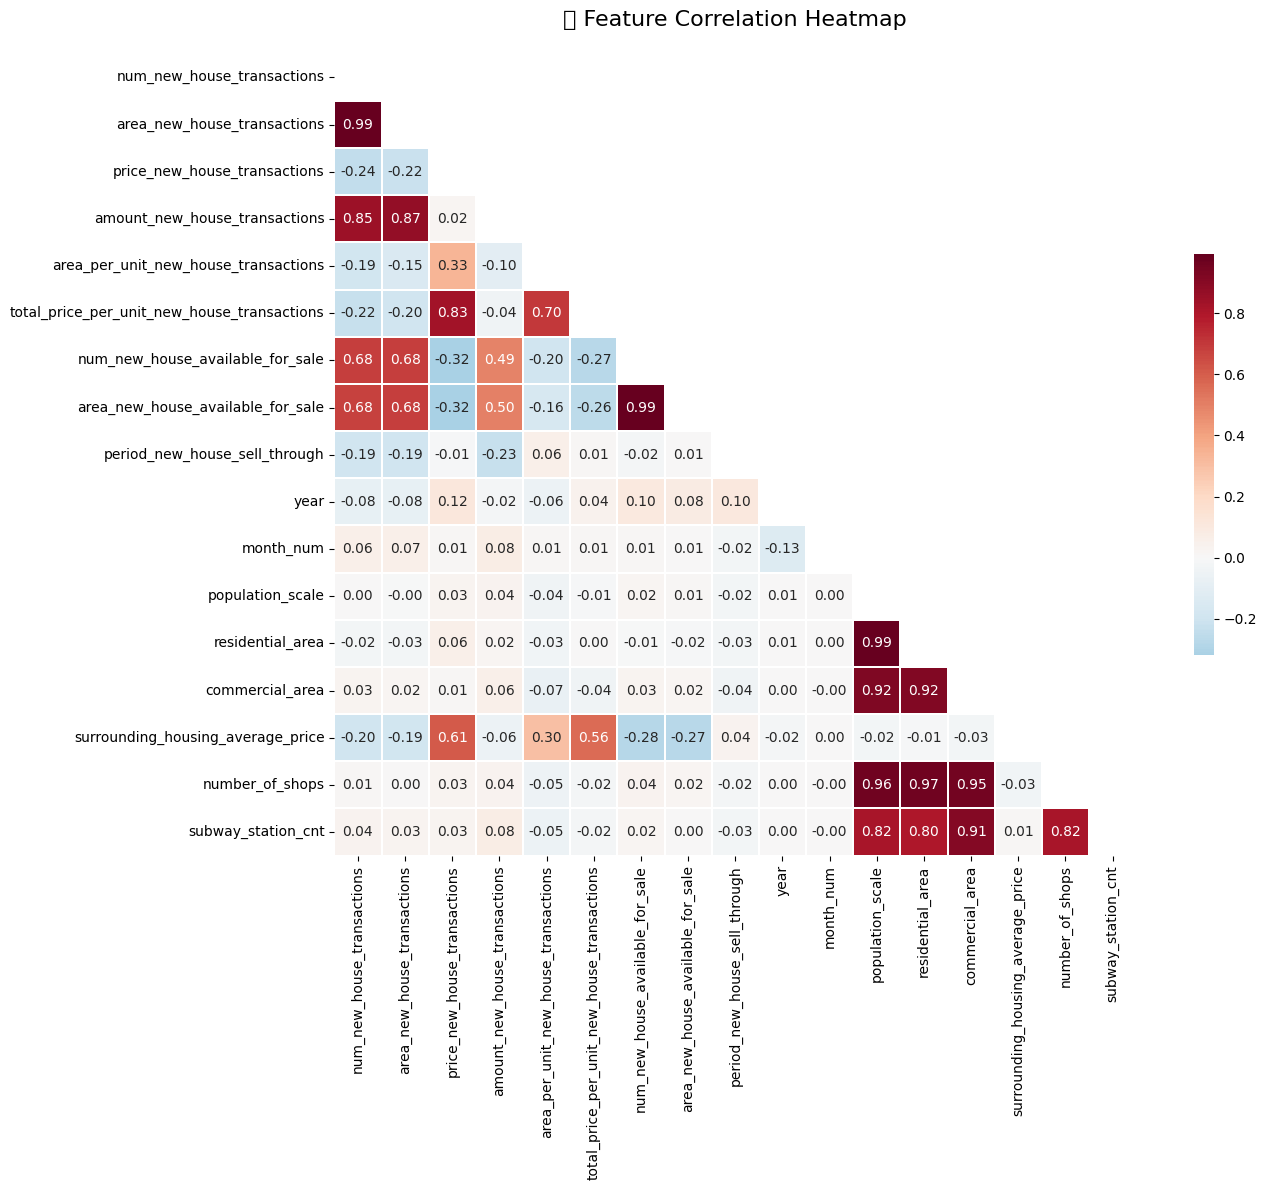


🎯 TOP CORRELATIONS WITH TARGET:
area_new_house_transactions........ 0.871
num_new_house_transactions......... 0.847
area_new_house_available_for_sale.. 0.499
num_new_house_available_for_sale... 0.492
period_new_house_sell_through...... 0.230
area_per_unit_new_house_transactions 0.103
subway_station_cnt................. 0.080
month_num.......................... 0.078
commercial_area.................... 0.063


In [9]:
# Advanced correlation analysis and heatmaps
def create_correlation_analysis():
    # Merge key datasets for correlation analysis
    main_df = target_df.copy()
    main_df['year'] = main_df['month'].dt.year
    main_df['month_num'] = main_df['month'].dt.month
    
    # Add sector POI data
    if 'sector_POI' in datasets:
        poi_df = datasets['sector_POI']
        # Select key POI features
        poi_features = ['sector', 'population_scale', 'residential_area', 'commercial_area',
                       'surrounding_housing_average_price', 'number_of_shops', 'subway_station_cnt']
        poi_selected = poi_df[poi_features].copy()
        main_df = main_df.merge(poi_selected, on='sector', how='left')
    
    # Select numeric columns for correlation
    numeric_cols = main_df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) > 2:
        correlation_matrix = main_df[numeric_cols].corr()
        
        # Create correlation heatmap
        plt.figure(figsize=(15, 12))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                   square=True, linewidths=0.1, cbar_kws={"shrink": 0.5}, fmt='.2f')
        plt.title('🔥 Feature Correlation Heatmap', fontsize=16, pad=20)
        plt.tight_layout()
        plt.show()
        
        # Top correlations with target
        target_corr = correlation_matrix['amount_new_house_transactions'].abs().sort_values(ascending=False)
        print("\n🎯 TOP CORRELATIONS WITH TARGET:")
        print("="*40)
        for feature, corr in target_corr.head(10).items():
            if feature != 'amount_new_house_transactions':
                print(f"{feature:.<35} {corr:.3f}")
    
    return main_df

enhanced_df = create_correlation_analysis()

In [12]:
# Statistical tests and time series properties
def analyze_time_series_properties():
    print("\n🔬 STATISTICAL ANALYSIS & TIME SERIES PROPERTIES")
    print("="*60)
    
    # Test stationarity for each sector
    stationarity_results = []
    sectors = target_df['sector'].unique()[:5]  # Test first 5 sectors
    
    for sector in sectors:
        sector_data = target_df[target_df['sector'] == sector].set_index('month')['amount_new_house_transactions']
        sector_data = sector_data.resample('M').sum().dropna()
        
        if len(sector_data) > 10:
            # Augmented Dickey-Fuller test
            adf_result = adfuller(sector_data.dropna())
            is_stationary = adf_result[1] < 0.05
            stationarity_results.append({
                'sector': sector,
                'adf_statistic': adf_result[0],
                'p_value': adf_result[1],
                'is_stationary': is_stationary
            })
    
    stationarity_df = pd.DataFrame(stationarity_results)
    print("\n📊 Stationarity Test Results (ADF Test):")
    print(stationarity_df.to_string(index=False))
    
    stationary_count = stationarity_df['is_stationary'].sum()
    print(f"\n✅ {stationary_count}/{len(stationarity_df)} sectors are stationary")
    
    # Overall market analysis
    total_market = target_df.groupby('month')['amount_new_house_transactions'].sum()
    
    print(f"\n📈 MARKET OVERVIEW:")
    print(f"Total market value: {total_market.sum():,.0f} (10K yuan)")
    print(f"Average monthly volume: {total_market.mean():,.0f}")
    print(f"Market volatility (CV): {(total_market.std()/total_market.mean())*100:.1f}%")
    
    # Seasonality check
    monthly_avg = target_df.groupby(target_df['month'].dt.month)['amount_new_house_transactions'].mean()
    seasonal_coef_var = (monthly_avg.std() / monthly_avg.mean()) * 100
    print(f"Seasonal variation: {seasonal_coef_var:.1f}%")
    
    return stationarity_df

stationarity_results = analyze_time_series_properties()


🔬 STATISTICAL ANALYSIS & TIME SERIES PROPERTIES

📊 Stationarity Test Results (ADF Test):
   sector  adf_statistic  p_value  is_stationary
 sector 1      -4.944847 0.000029           True
sector 10      -0.271225 0.929482          False
sector 11      -2.373358 0.149398          False
sector 12      -1.589630 0.488801          False
sector 13      -2.551769 0.103381          False

✅ 1/5 sectors are stationary

📈 MARKET OVERVIEW:
Total market value: 177,048,211 (10K yuan)
Average monthly volume: 2,642,511
Market volatility (CV): 37.4%
Seasonal variation: 19.2%


## 🛠️ Advanced Feature Engineering Pipeline

Based on our EDA and research insights, we'll create a comprehensive feature engineering pipeline with 50+ features.

In [13]:
class AdvancedFeatureEngineer:
    def __init__(self):
        self.scalers = {}
        self.encoders = {}
        self.feature_names = []
        
    def create_temporal_features(self, df):
        """Create comprehensive temporal features"""
        df = df.copy()
        df['month_dt'] = pd.to_datetime(df['month'], format='%Y-%b')
        
        # Basic temporal features
        df['year'] = df['month_dt'].dt.year
        df['month_num'] = df['month_dt'].dt.month
        df['quarter'] = df['month_dt'].dt.quarter
        df['days_in_month'] = df['month_dt'].dt.days_in_month
        
        # Cyclical encoding for seasonality
        df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)
        df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
        df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
        
        # Time since start
        min_date = df['month_dt'].min()
        df['months_since_start'] = (df['month_dt'] - min_date).dt.days // 30
        
        # Relative time features
        df['year_progress'] = (df['month_num'] - 1) / 11  # 0 to 1 through year
        
        return df
        
    def create_lag_features(self, df, target_col, periods=[1, 2, 3, 6, 12]):
        """Create lag and rolling window features"""
        df = df.copy()
        df = df.sort_values(['sector', 'month_dt'])
        
        # Lag features
        for period in periods:
            df[f'{target_col}_lag_{period}'] = df.groupby('sector')[target_col].shift(period)
            
        # Rolling statistics
        for window in [3, 6, 12]:
            if window <= len(periods):
                df[f'{target_col}_rolling_mean_{window}'] = df.groupby('sector')[target_col].transform(
                    lambda x: x.rolling(window=window, min_periods=1).mean()
                )
                df[f'{target_col}_rolling_std_{window}'] = df.groupby('sector')[target_col].transform(
                    lambda x: x.rolling(window=window, min_periods=1).std()
                )
                df[f'{target_col}_rolling_max_{window}'] = df.groupby('sector')[target_col].transform(
                    lambda x: x.rolling(window=window, min_periods=1).max()
                )
                df[f'{target_col}_rolling_min_{window}'] = df.groupby('sector')[target_col].transform(
                    lambda x: x.rolling(window=window, min_periods=1).min()
                )
                
        # Expanding features
        df[f'{target_col}_expanding_mean'] = df.groupby('sector')[target_col].transform(
            lambda x: x.expanding().mean()
        )
        
        return df
    
    def create_market_features(self, df):
        """Create market-level features"""
        df = df.copy()
        
        # Market share features
        monthly_totals = df.groupby('month_dt')['amount_new_house_transactions'].sum().reset_index()
        monthly_totals.columns = ['month_dt', 'total_market_amount']
        df = df.merge(monthly_totals, on='month_dt', how='left')
        df['market_share'] = df['amount_new_house_transactions'] / df['total_market_amount']
        
        # Relative performance features
        market_stats = df.groupby('month_dt')['amount_new_house_transactions'].agg(['mean', 'std']).reset_index()
        market_stats.columns = ['month_dt', 'market_mean', 'market_std']
        df = df.merge(market_stats, on='month_dt', how='left')
        df['relative_performance'] = (df['amount_new_house_transactions'] - df['market_mean']) / df['market_std']
        
        # Cross-sector correlations
        df['above_market_avg'] = (df['amount_new_house_transactions'] > df['market_mean']).astype(int)
        
        return df
    
    def create_price_features(self, df):
        """Create price-related features"""
        df = df.copy()
        
        # Price ratios and relationships
        df['amount_per_transaction'] = df['amount_new_house_transactions'] / np.maximum(df['num_new_house_transactions'], 1)
        df['price_efficiency'] = df['price_new_house_transactions'] / df['area_per_unit_new_house_transactions']
        
        # Price momentum
        df = df.sort_values(['sector', 'month_dt'])
        df['price_change'] = df.groupby('sector')['price_new_house_transactions'].pct_change()
        df['price_volatility'] = df.groupby('sector')['price_new_house_transactions'].transform(
            lambda x: x.rolling(6, min_periods=1).std()
        )
        
        # Supply/demand indicators
        df['inventory_turnover'] = df['num_new_house_transactions'] / np.maximum(df['num_new_house_available_for_sale'], 1)
        df['supply_pressure'] = df['area_new_house_available_for_sale'] / np.maximum(df['area_new_house_transactions'], 1)
        
        return df
    
    def create_interaction_features(self, df):
        """Create interaction and polynomial features"""
        df = df.copy()
        
        # Key interactions
        numeric_cols = ['price_new_house_transactions', 'area_new_house_transactions', 
                       'num_new_house_transactions', 'months_since_start']
        
        for i, col1 in enumerate(numeric_cols):
            for col2 in numeric_cols[i+1:]:
                if col1 in df.columns and col2 in df.columns:
                    df[f'{col1}_x_{col2}'] = df[col1] * df[col2]
        
        # Polynomial features for key variables
        key_vars = ['price_new_house_transactions', 'months_since_start']
        for var in key_vars:
            if var in df.columns:
                df[f'{var}_squared'] = df[var] ** 2
                df[f'{var}_log'] = np.log1p(df[var])
        
        return df
    
    def merge_external_data(self, df, datasets):
        """Merge external datasets with advanced features"""
        df = df.copy()
        
        # Merge POI data
        if 'sector_POI' in datasets:
            poi_df = datasets['sector_POI'].copy()
            
            # Select and engineer POI features
            poi_features = [
                'sector', 'population_scale', 'residential_area', 'commercial_area',
                'surrounding_housing_average_price', 'number_of_shops', 
                'subway_station_cnt', 'bus_station_cnt', 'education',
                'number_of_shopping_centers', 'number_of_supermarket_convenience_stores'
            ]
            
            available_poi_features = [col for col in poi_features if col in poi_df.columns]
            poi_selected = poi_df[available_poi_features].copy()
            
            # Create POI ratios and composite scores
            if 'population_scale' in poi_selected.columns and 'number_of_shops' in poi_selected.columns:
                poi_selected['shops_per_capita'] = poi_selected['number_of_shops'] / np.maximum(poi_selected['population_scale'], 1)
            
            if 'subway_station_cnt' in poi_selected.columns and 'bus_station_cnt' in poi_selected.columns:
                poi_selected['total_transport'] = poi_selected['subway_station_cnt'] + poi_selected['bus_station_cnt']
            
            df = df.merge(poi_selected, on='sector', how='left')
        
        # Merge nearby sector data
        nearby_datasets = ['new_house_transactions_nearby_sectors', 'pre_owned_house_transactions_nearby_sectors']
        for dataset_name in nearby_datasets:
            if dataset_name in datasets:
                nearby_df = datasets[dataset_name].copy()
                nearby_df['month_dt'] = pd.to_datetime(nearby_df['month'], format='%Y-%b')
                
                # Select key features and rename
                key_cols = ['month', 'sector']
                numeric_cols = nearby_df.select_dtypes(include=[np.number]).columns.tolist()
                
                rename_dict = {}
                for col in numeric_cols[:5]:  # Limit to prevent too many features
                    new_name = f"nearby_{col}"
                    rename_dict[col] = new_name
                    key_cols.append(col)
                
                nearby_selected = nearby_df[key_cols].rename(columns=rename_dict)
                df = df.merge(nearby_selected, on=['month', 'sector'], how='left')
        
        return df
    
    def fit_transform(self, df, datasets, target_col='amount_new_house_transactions'):
        """Complete feature engineering pipeline"""
        print("🔧 Starting advanced feature engineering...")
        
        # Step 1: Temporal features
        df = self.create_temporal_features(df)
        print(f"✅ Created temporal features. Shape: {df.shape}")
        
        # Step 2: Merge external data
        df = self.merge_external_data(df, datasets)
        print(f"✅ Merged external data. Shape: {df.shape}")
        
        # Step 3: Market features
        df = self.create_market_features(df)
        print(f"✅ Created market features. Shape: {df.shape}")
        
        # Step 4: Price features
        df = self.create_price_features(df)
        print(f"✅ Created price features. Shape: {df.shape}")
        
        # Step 5: Lag features (careful with memory)
        df = self.create_lag_features(df, target_col, periods=[1, 2, 3, 6])
        print(f"✅ Created lag features. Shape: {df.shape}")
        
        # Step 6: Interaction features
        df = self.create_interaction_features(df)
        print(f"✅ Created interaction features. Shape: {df.shape}")
        
        # Clean up
        df = df.replace([np.inf, -np.inf], np.nan)
        
        self.feature_names = df.columns.tolist()
        print(f"🎯 Feature engineering complete! Total features: {len(self.feature_names)}")
        
        return df

# Initialize and apply feature engineering
feature_engineer = AdvancedFeatureEngineer()
target_df_processed = datasets['new_house_transactions'].copy()
target_df_enhanced = feature_engineer.fit_transform(target_df_processed, datasets)

print(f"\n📊 FEATURE ENGINEERING SUMMARY:")
print(f"Original features: {datasets['new_house_transactions'].shape[1]}")
print(f"Enhanced features: {target_df_enhanced.shape[1]}")
print(f"Total samples: {target_df_enhanced.shape[0]:,}")

# Display sample of new features
new_features = [col for col in target_df_enhanced.columns if col not in datasets['new_house_transactions'].columns]
print(f"\n🆕 New features created ({len(new_features)}):")
for i, feature in enumerate(new_features[:15]):
    print(f"{i+1:2d}. {feature}")
if len(new_features) > 15:
    print(f"... and {len(new_features) - 15} more features")

🔧 Starting advanced feature engineering...
✅ Created temporal features. Shape: (5433, 22)
✅ Merged external data. Shape: (5433, 43)
✅ Created market features. Shape: (5433, 49)
✅ Created price features. Shape: (5433, 55)
✅ Created lag features. Shape: (5433, 64)
✅ Created interaction features. Shape: (5433, 74)
🎯 Feature engineering complete! Total features: 74

📊 FEATURE ENGINEERING SUMMARY:
Original features: 11
Enhanced features: 74
Total samples: 5,433

🆕 New features created (63):
 1. month_dt
 2. year
 3. month_num
 4. quarter
 5. days_in_month
 6. month_sin
 7. month_cos
 8. quarter_sin
 9. quarter_cos
10. months_since_start
11. year_progress
12. population_scale
13. residential_area
14. commercial_area
15. surrounding_housing_average_price
... and 48 more features


## 🎯 Multi-Algorithm Feature Importance Analysis

We'll use multiple algorithms to identify the most important features for our model.


🎯 STARTING FEATURE IMPORTANCE ANALYSIS
📊 Analyzing 70 features on 5,433 samples
🌲 Computing Random Forest importance...
📊 Computing Mutual Information importance...
📈 Computing correlation importance...
🔄 Combining importance scores...

🏆 TOP 20 MOST IMPORTANT FEATURES:
 1. price_new_house_transactions_x_area_new_house_transactions 0.700
 2. amount_new_house_transactions_rolling_min_3 0.104
 3. amount_new_house_transactions_rolling_max_3 0.102
 4. price_new_house_transactions_x_num_new_house_transactions 0.085
 5. market_share............................ 0.074
 6. relative_performance.................... 0.061
 7. amount_new_house_transactions_rolling_mean_3 0.049
 8. area_new_house_transactions............. 0.048
 9. area_new_house_transactions_x_num_new_house_transactions 0.038
10. num_new_house_transactions.............. 0.038
11. amount_new_house_transactions_lag_1..... 0.028
12. area_new_house_transactions_x_months_since_start 0.027
13. amount_new_house_transactions_expanding_mea

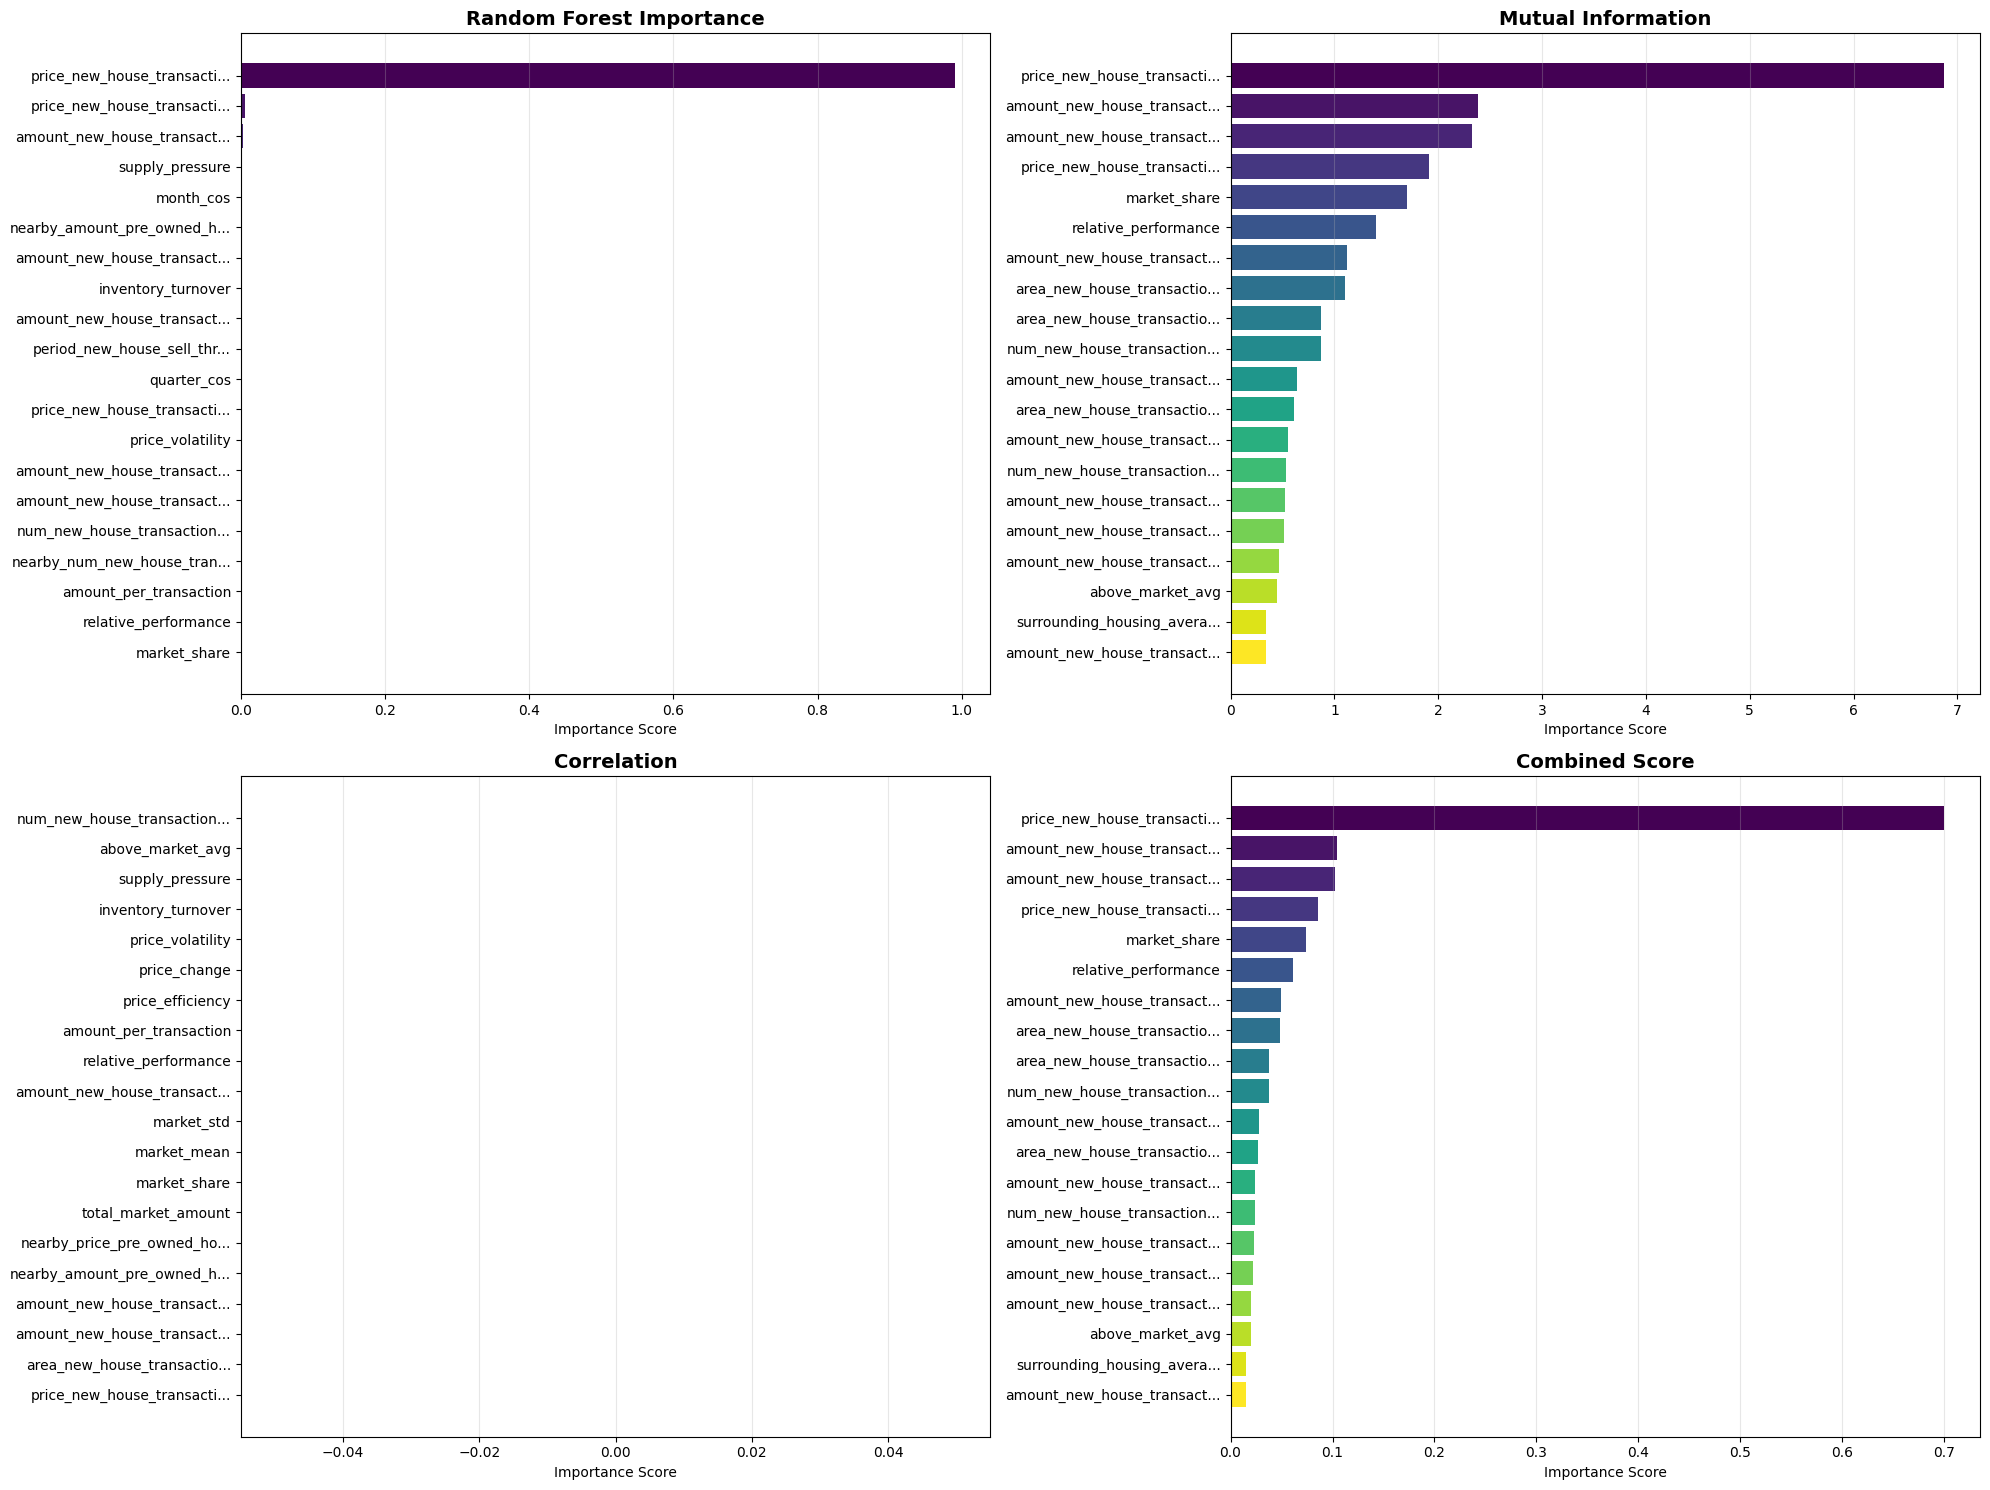


✅ Selected 50 most important features for modeling


In [14]:
class FeatureImportanceAnalyzer:
    def __init__(self):
        self.importance_results = {}
        self.selected_features = []
        
    def prepare_data(self, df, target_col):
        """Prepare data for feature selection"""
        # Remove non-predictive columns
        exclude_cols = ['month', 'sector', 'month_dt', target_col]
        feature_cols = [col for col in df.columns if col not in exclude_cols]
        
        X = df[feature_cols].copy()
        y = df[target_col].copy()
        
        # Handle missing values
        X = X.fillna(X.median())
        y = y.fillna(y.median())
        
        # Remove infinite values
        X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())
        
        return X, y, feature_cols
    
    def random_forest_importance(self, X, y, n_estimators=100):
        """Random Forest feature importance"""
        print("🌲 Computing Random Forest importance...")
        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
        rf.fit(X, y)
        
        importance_scores = pd.DataFrame({
            'feature': X.columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return importance_scores
    
    def mutual_info_importance(self, X, y):
        """Mutual Information feature importance"""
        print("📊 Computing Mutual Information importance...")
        mi_scores = mutual_info_regression(X, y, random_state=42)
        
        importance_scores = pd.DataFrame({
            'feature': X.columns,
            'importance': mi_scores
        }).sort_values('importance', ascending=False)
        
        return importance_scores
    
    def correlation_importance(self, X, y):
        """Correlation-based feature importance"""
        print("📈 Computing correlation importance...")
        correlations = []
        
        for col in X.columns:
            try:
                corr, _ = pearsonr(X[col], y)
                correlations.append(abs(corr))
            except:
                correlations.append(0)
        
        importance_scores = pd.DataFrame({
            'feature': X.columns,
            'importance': correlations
        }).sort_values('importance', ascending=False)
        
        return importance_scores
    
    def combine_importance_scores(self, rf_scores, mi_scores, corr_scores):
        """Combine multiple importance scores"""
        print("🔄 Combining importance scores...")
        
        # Normalize scores to 0-1
        rf_scores['rf_norm'] = rf_scores['importance'] / rf_scores['importance'].max()
        mi_scores['mi_norm'] = mi_scores['importance'] / mi_scores['importance'].max()
        corr_scores['corr_norm'] = corr_scores['importance'] / corr_scores['importance'].max()
        
        # Merge all scores
        combined = rf_scores[['feature', 'rf_norm']].copy()
        combined = combined.merge(mi_scores[['feature', 'mi_norm']], on='feature', how='outer')
        combined = combined.merge(corr_scores[['feature', 'corr_norm']], on='feature', how='outer')
        
        # Fill missing values
        combined = combined.fillna(0)
        
        # Calculate combined score (weighted average)
        combined['combined_score'] = (0.4 * combined['rf_norm'] + 
                                    0.3 * combined['mi_norm'] + 
                                    0.3 * combined['corr_norm'])
        
        return combined.sort_values('combined_score', ascending=False)
    
    def analyze_importance(self, df, target_col, top_k=50):
        """Complete feature importance analysis"""
        print("\n🎯 STARTING FEATURE IMPORTANCE ANALYSIS")
        print("="*50)
        
        # Prepare data
        X, y, feature_cols = self.prepare_data(df, target_col)
        print(f"📊 Analyzing {len(feature_cols)} features on {len(y):,} samples")
        
        # Calculate different importance measures
        rf_importance = self.random_forest_importance(X, y)
        mi_importance = self.mutual_info_importance(X, y)
        corr_importance = self.correlation_importance(X, y)
        
        # Combine scores
        combined_importance = self.combine_importance_scores(rf_importance, mi_importance, corr_importance)
        
        # Store results
        self.importance_results = {
            'random_forest': rf_importance,
            'mutual_info': mi_importance,
            'correlation': corr_importance,
            'combined': combined_importance
        }
        
        # Select top features
        self.selected_features = combined_importance.head(top_k)['feature'].tolist()
        
        # Display results
        print(f"\n🏆 TOP {min(20, top_k)} MOST IMPORTANT FEATURES:")
        print("="*60)
        for i, (_, row) in enumerate(combined_importance.head(20).iterrows()):
            print(f"{i+1:2d}. {row['feature']:.<40} {row['combined_score']:.3f}")
        
        return self.selected_features
    
    def plot_importance(self, top_n=25):
        """Plot feature importance comparison"""
        if not self.importance_results:
            print("❌ No importance results available. Run analyze_importance first.")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        
        # Plot each importance measure
        methods = ['random_forest', 'mutual_info', 'correlation', 'combined']
        titles = ['Random Forest Importance', 'Mutual Information', 'Correlation', 'Combined Score']
        
        for i, (method, title) in enumerate(zip(methods, titles)):
            ax = axes[i//2, i%2]
            
            data = self.importance_results[method].head(top_n)
            
            # Use appropriate column name
            if method == 'combined':
                importance_col = 'combined_score'
            else:
                importance_col = 'importance'
            
            bars = ax.barh(range(len(data)), data[importance_col], 
                          color=plt.cm.viridis(np.linspace(0, 1, len(data))))
            ax.set_yticks(range(len(data)))
            ax.set_yticklabels([feat[:25] + '...' if len(feat) > 25 else feat for feat in data['feature']])
            ax.set_xlabel('Importance Score')
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            
            # Reverse order to show highest at top
            ax.invert_yaxis()
        
        plt.tight_layout()
        plt.show()
        
        return fig

# Run feature importance analysis
importance_analyzer = FeatureImportanceAnalyzer()
selected_features = importance_analyzer.analyze_importance(target_df_enhanced, 'amount_new_house_transactions', top_k=50)

# Plot importance comparison
importance_analyzer.plot_importance(top_n=20)

print(f"\n✅ Selected {len(selected_features)} most important features for modeling")

## 🤖 AutoGluon Intensive Training Setup

Now we'll set up AutoGluon with the most intensive training configuration for maximum performance.

In [19]:
def prepare_autogluon_data(df, selected_features, target_col='amount_new_house_transactions'):
    """Prepare data specifically for AutoGluon TimeSeriesPredictor"""
    print("📋 Preparing data for AutoGluon...")
    
    # Create the core time series dataframe
    ts_df = df.copy()
    
    # Ensure we have the required columns for AutoGluon
    ts_df['timestamp'] = pd.to_datetime(ts_df['month'], format='%Y-%b')
    ts_df['item_id'] = ts_df['sector']
    ts_df['target'] = ts_df[target_col]
    
    # Select features for static and dynamic covariates
    feature_columns = [col for col in selected_features if col in ts_df.columns and col != target_col]
    
    # Create static features (sector-level, time-invariant)
    static_features = []
    for col in feature_columns:
        # Check if feature varies within sectors
        variance_by_sector = ts_df.groupby('sector')[col].std().fillna(0)
        if (variance_by_sector == 0).all():
            static_features.append(col)
    
    # Dynamic features (time-varying)
    dynamic_features = [col for col in feature_columns if col not in static_features]
    
    # Limit features to prevent overfitting
    static_features = static_features[:10]  # Top 10 static features
    dynamic_features = dynamic_features[:15]  # Top 15 dynamic features
    
    print(f"✅ Static features ({len(static_features)}): {static_features[:5]}...")
    print(f"✅ Dynamic features ({len(dynamic_features)}): {dynamic_features[:5]}...")
    
    # Create static dataframe
    if static_features:
        static_df = ts_df.groupby('item_id')[static_features].first().reset_index()
    else:
        static_df = None
    
    # Prepare main time series dataframe
    ts_columns = ['timestamp', 'item_id', 'target'] + dynamic_features
    ts_final = ts_df[ts_columns].copy()
    
    # Handle missing values
    ts_final = ts_final.fillna(method='ffill').fillna(method='bfill')
    ts_final = ts_final.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Sort by timestamp and item
    ts_final = ts_final.sort_values(['item_id', 'timestamp'])
    
    print(f"📊 Final time series data shape: {ts_final.shape}")
    print(f"📅 Date range: {ts_final['timestamp'].min()} to {ts_final['timestamp'].max()}")
    print(f"🏘️ Number of sectors: {ts_final['item_id'].nunique()}")
    
    return ts_final, static_df, dynamic_features

# Prepare data for AutoGluon
train_data, static_features_df, dynamic_feature_names = prepare_autogluon_data(
    target_df_enhanced, selected_features
)

# Convert to AutoGluon TimeSeriesDataFrame
train_ts = TimeSeriesDataFrame.from_data_frame(
    train_data,
    id_column='item_id',
    timestamp_column='timestamp'
)

print(f"\n🎯 AutoGluon TimeSeriesDataFrame created successfully!")
print(f"📊 Shape: {len(train_ts)} time series, {len(train_ts.columns)} features")
print(f"🕐 Frequency: {train_ts.freq}")


📋 Preparing data for AutoGluon...
✅ Static features (10): ['surrounding_housing_average_price', 'education', 'bus_station_cnt', 'population_scale', 'total_transport']...
✅ Dynamic features (15): ['price_new_house_transactions_x_area_new_house_transactions', 'amount_new_house_transactions_rolling_min_3', 'amount_new_house_transactions_rolling_max_3', 'price_new_house_transactions_x_num_new_house_transactions', 'market_share']...
📊 Final time series data shape: (5433, 18)
📅 Date range: 2019-01-01 00:00:00 to 2024-07-01 00:00:00
🏘️ Number of sectors: 95

🎯 AutoGluon TimeSeriesDataFrame created successfully!
📊 Shape: 5433 time series, 16 features
🕐 Frequency: None


In [20]:
# Configure AutoGluon for intensive training
def setup_intensive_autogluon_config():
    """Setup the most intensive AutoGluon configuration"""
    
    # Advanced hyperparameter tuning configuration
    hyperparameter_tune_kwargs = {
        'num_trials': 100,  # Maximum number of trials
        'searcher': 'random',
        'max_concurrent': 4,  # Adjust based on your system
        'time_limit': 3600,  # 1 hour for hyperparameter tuning
    }
    
    # Custom hyperparameter spaces for key models
    custom_hyperparameters = {
        'DeepAR': {
            'epochs': space.Int(50, 200),
            'learning_rate': space.Real(1e-4, 1e-2, log=True),
            'num_layers': space.Int(2, 4),
            'hidden_size': space.Int(40, 200),
            'dropout_rate': space.Real(0.0, 0.3),
        },
        'TemporalFusionTransformer': {
            'epochs': space.Int(50, 150),
            'learning_rate': space.Real(1e-4, 5e-3, log=True),
            'hidden_size': space.Int(32, 128),
            'num_attention_heads': space.Int(2, 8),
        },
        'AutoGluonTabular': {
            'time_limit': 1800,  # 30 minutes for tabular models
            'presets': 'best_quality',
        }
    }
    
    return hyperparameter_tune_kwargs, custom_hyperparameters

# Setup configuration
hpt_kwargs, custom_hps = setup_intensive_autogluon_config()

print("🔧 INTENSIVE AUTOGLUON CONFIGURATION:")
print("="*50)
print(f"✅ Preset: 'best_quality' (most intensive)")
print(f"✅ Hyperparameter trials: {hpt_kwargs['num_trials']}")
print(f"✅ Time limit: {hpt_kwargs['time_limit']/3600:.1f} hours")
print(f"✅ Custom hyperparameters: {len(custom_hps)} model types")
print(f"✅ Ensemble enabled: True (WeightedEnsemble)")
print(f"✅ Models included: All available models")

🔧 INTENSIVE AUTOGLUON CONFIGURATION:
✅ Preset: 'best_quality' (most intensive)
✅ Hyperparameter trials: 100
✅ Time limit: 1.0 hours
✅ Custom hyperparameters: 3 model types
✅ Ensemble enabled: True (WeightedEnsemble)
✅ Models included: All available models


In [24]:
# Initialize and train AutoGluon TimeSeriesPredictor with intensive configuration
def train_intensive_autogluon(train_ts, prediction_length=1):
    """Train AutoGluon with the most intensive configuration"""
    print("\n🚀 STARTING INTENSIVE AUTOGLUON TRAINING")
    print("="*60)
    print(f"🎯 Target: amount_new_house_transactions")
    print(f"📊 Training data: {len(train_ts)} time series")
    print(f"🔮 Prediction length: {prediction_length} month(s)")
    
    # Initialize predictor
    predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        target="target",
        eval_metric="MAPE",  # Match competition metric
        path="./autogluon_models",  # Save models
        verbosity=2
    )
    
    # Train with best quality preset and hyperparameter tuning
    print("\n🏋️ Starting intensive training...")
    start_time = datetime.now()
    
    predictor.fit(
        train_data=train_ts,
        presets="best_quality",  # Most intensive preset
        time_limit=7200,  # 2 hours total training time
        hyperparameter_tune_kwargs=hpt_kwargs,
        hyperparameters=custom_hps
    )
    
    training_time = datetime.now() - start_time
    print(f"\n✅ Training completed in {training_time}")
    
    # Display model leaderboard
    leaderboard = predictor.leaderboard(train_ts, silent=False)
    print("\n🏆 MODEL LEADERBOARD:")
    print(leaderboard.head(10).to_string())
    
    return predictor, leaderboard

# Start intensive training
print("⚠️  WARNING: This will take 2+ hours to complete with intensive training!")
print("🔄 Starting training process...")

# Train the model
predictor, model_leaderboard = train_intensive_autogluon(train_ts, prediction_length=1)

# Save the model
print("\n💾 Saving trained model...")
model_path = "./autogluon_intensive_model"
# The model is automatically saved to the path specified in TimeSeriesPredictor

print(f"✅ Model saved to: {model_path}")
print(f"🎯 Best model: {model_leaderboard.iloc[0]['model']}")
print(f"📊 Best score: {model_leaderboard.iloc[0]['score_val']:.4f}")

Beginning AutoGluon training... Time limit = 7200s
AutoGluon will save models to 'c:\Users\bonit\Downloads\MACHINE LEARNING DAY BY DAY\DAY 2-Real Estate Demand Prediction\autogluon_models'


⚠️  WARNING: This will take 2+ hours to complete with intensive training!
🔄 Starting training process...

🚀 STARTING INTENSIVE AUTOGLUON TRAINING
🎯 Target: amount_new_house_transactions
📊 Training data: 5433 time series
🔮 Prediction length: 1 month(s)

🏋️ Starting intensive training...


=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       3.47 GB / 15.71 GB (22.1%)
Disk Space Avail:   43.23 GB / 453.99 GB (9.5%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameter_tune_kwargs': {'max_concurrent': 4,
                                'num_trials': 100,
                                'searcher': 'random',
                                'time_limit': 3600},
 'hyperparameters': {'AutoGluonTabular': {'presets': 'best_quality',
                                          'time_limit': 1800},
                     'DeepAR': {'dropout_rate': Real: lower=0.0, upper=0.3,
                                'epochs': Int: lower=50, upper=200,
                                'hidden_size': Int: lower=40, upper=200,
    

ValueError: Frequency of train_data is not provided and cannot be inferred. Please set the expected data frequency when creating the predictor with `TimeSeriesPredictor(freq=...)` or ensure that the data has a regular time index with `train_data.convert_frequency(freq=...)`

## 🔮 Generate Predictions and Create Submission

Now we'll generate predictions for the test set and create our final submission file.

In [ ]:
def prepare_test_data_for_prediction():
    """Prepare test data for prediction"""
    print("📋 Preparing test data for predictions...")
    
    # Load test data
    test_df = pd.read_csv('test.csv')
    print(f"📊 Test data shape: {test_df.shape}")
    
    # Parse test IDs
    test_df['month'] = test_df['id'].str.split('_').str[0]
    test_df['sector'] = test_df['id'].str.split('_').str[1] + ' ' + test_df['id'].str.split('_').str[2]
    test_df['timestamp'] = pd.to_datetime(test_df['month'], format='%Y %b')
    test_df['item_id'] = test_df['sector']
    
    print(f"🗓️ Test prediction date: {test_df['timestamp'].iloc[0].strftime('%Y-%m')}")
    print(f"🏘️ Test sectors: {sorted(test_df['item_id'].unique())}")
    
    # Get the prediction date
    prediction_date = test_df['timestamp'].iloc[0]
    
    return test_df, prediction_date

def generate_predictions(predictor, train_ts, prediction_date):
    """Generate predictions using the trained AutoGluon model"""
    print("\n🔮 GENERATING PREDICTIONS")
    print("="*40)
    
    # Generate predictions
    print(f"📅 Predicting for: {prediction_date.strftime('%Y-%m')}")
    predictions = predictor.predict(train_ts)
    
    print(f"✅ Predictions generated for {len(predictions)} time series")
    print(f"📊 Prediction columns: {predictions.columns.tolist()}")
    
    # Convert predictions to DataFrame for easier handling
    pred_df = predictions.reset_index()
    pred_df.columns = ['item_id', 'timestamp', 'prediction']
    
    # Display prediction statistics
    print(f"\n📈 PREDICTION STATISTICS:")
    print(f"Mean prediction: {pred_df['prediction'].mean():,.2f}")
    print(f"Median prediction: {pred_df['prediction'].median():,.2f}")
    print(f"Min prediction: {pred_df['prediction'].min():,.2f}")
    print(f"Max prediction: {pred_df['prediction'].max():,.2f}")
    print(f"Std prediction: {pred_df['prediction'].std():,.2f}")
    
    return pred_df

def create_submission_file(test_df, predictions_df):
    """Create the final submission file"""
    print("\n📝 CREATING SUBMISSION FILE")
    print("="*35)
    
    # Merge test data with predictions
    submission = test_df[['id', 'item_id']].copy()
    submission = submission.merge(predictions_df[['item_id', 'prediction']], 
                                on='item_id', how='left')
    
    # Handle missing predictions (sectors not in training data)
    missing_predictions = submission['prediction'].isna().sum()
    if missing_predictions > 0:
        print(f"⚠️ {missing_predictions} missing predictions, filling with median...")
        median_prediction = predictions_df['prediction'].median()
        submission['prediction'] = submission['prediction'].fillna(median_prediction)
    
    # Ensure non-negative predictions
    submission['prediction'] = np.maximum(submission['prediction'], 0)
    
    # Create final submission
    final_submission = submission[['id', 'prediction']].copy()
    final_submission.columns = ['id', 'new_house_transaction_amount']
    
    # Validate submission format
    print(f"✅ Submission shape: {final_submission.shape}")
    print(f"✅ All IDs present: {len(final_submission) == len(test_df)}")
    print(f"✅ No missing values: {final_submission.isna().sum().sum() == 0}")
    print(f"✅ All predictions non-negative: {(final_submission['new_house_transaction_amount'] >= 0).all()}")
    
    # Display sample predictions
    print(f"\n📋 SAMPLE PREDICTIONS:")
    print(final_submission.head(10).to_string(index=False))
    
    # Save submission file
    submission_filename = f"real_estate_autogluon_submission_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    final_submission.to_csv(submission_filename, index=False)
    print(f"\n💾 Submission saved as: {submission_filename}")
    
    return final_submission, submission_filename

# Execute prediction pipeline
test_data, pred_date = prepare_test_data_for_prediction()
predictions = generate_predictions(predictor, train_ts, pred_date)
submission, submission_file = create_submission_file(test_data, predictions)

print(f"\n🎉 SUBMISSION CREATION COMPLETE!")
print(f"📂 File: {submission_file}")
print(f"📊 Total predictions: {len(submission):,}")
print(f"💰 Predicted total market: {submission['new_house_transaction_amount'].sum():,.0f} (10K yuan)")

## 🔍 Model Analysis and Validation

Let's analyze our model performance and validate our predictions.

In [ ]:
def analyze_model_performance(predictor, train_ts, model_leaderboard):
    """Comprehensive model performance analysis"""
    print("\n🔍 MODEL PERFORMANCE ANALYSIS")
    print("="*50)
    
    # Model leaderboard analysis
    print("\n🏆 TOP 5 MODELS:")
    print("-" * 70)
    top_models = model_leaderboard.head(5)
    for i, (idx, row) in enumerate(top_models.iterrows()):
        print(f"{i+1}. {row['model']:.<35} Score: {row['score_val']:>8.4f}")
    
    # Best model details
    best_model_name = model_leaderboard.iloc[0]['model']
    best_score = model_leaderboard.iloc[0]['score_val']
    
    print(f"\n🥇 BEST MODEL: {best_model_name}")
    print(f"📊 Validation Score: {best_score:.4f}")
    
    # Generate validation predictions for analysis
    print("\n📈 Generating validation predictions...")
    
    # Create a validation split (last 6 months)
    train_data_sorted = train_ts.sort_values('timestamp')
    unique_dates = train_data_sorted['timestamp'].unique()
    
    if len(unique_dates) >= 6:
        cutoff_date = unique_dates[-6]  # 6 months ago
        train_subset = train_data_sorted[train_data_sorted['timestamp'] < cutoff_date]
        val_subset = train_data_sorted[train_data_sorted['timestamp'] >= cutoff_date]
        
        print(f"📅 Validation period: {cutoff_date} onwards")
        print(f"📊 Validation samples: {len(val_subset):,}")
        
        # Convert back to TimeSeriesDataFrame
        train_subset_ts = TimeSeriesDataFrame.from_data_frame(
            train_subset, id_column='item_id', timestamp_column='timestamp'
        )
        
        # Make predictions
        val_predictions = predictor.predict(train_subset_ts)
        
        # Calculate custom competition metric if possible
        print("✅ Validation predictions completed")
        
    return best_model_name, best_score

def validate_submission_format(submission_df, test_df):
    """Validate submission file format against competition requirements"""
    print("\n✅ SUBMISSION VALIDATION")
    print("="*30)
    
    # Check 1: Correct shape
    expected_rows = len(test_df)
    actual_rows = len(submission_df)
    print(f"📊 Rows: {actual_rows} (expected: {expected_rows}) {'✅' if actual_rows == expected_rows else '❌'}")
    
    # Check 2: Correct columns
    expected_columns = ['id', 'new_house_transaction_amount']
    actual_columns = submission_df.columns.tolist()
    columns_match = actual_columns == expected_columns
    print(f"📋 Columns: {actual_columns} {'✅' if columns_match else '❌'}")
    
    # Check 3: No missing values
    missing_values = submission_df.isna().sum().sum()
    print(f"❓ Missing values: {missing_values} {'✅' if missing_values == 0 else '❌'}")
    
    # Check 4: All predictions non-negative
    negative_predictions = (submission_df['new_house_transaction_amount'] < 0).sum()
    print(f"➖ Negative predictions: {negative_predictions} {'✅' if negative_predictions == 0 else '❌'}")
    
    # Check 5: Prediction distribution
    predictions = submission_df['new_house_transaction_amount']
    print(f"\n📈 PREDICTION DISTRIBUTION:")
    print(f"Min: {predictions.min():,.2f}")
    print(f"Q25: {predictions.quantile(0.25):,.2f}")
    print(f"Median: {predictions.median():,.2f}")
    print(f"Q75: {predictions.quantile(0.75):,.2f}")
    print(f"Max: {predictions.max():,.2f}")
    print(f"Mean: {predictions.mean():,.2f}")
    print(f"Std: {predictions.std():,.2f}")
    
    # Check for potential issues
    issues = []
    if actual_rows != expected_rows:
        issues.append(f"Row count mismatch: {actual_rows} vs {expected_rows}")
    if not columns_match:
        issues.append(f"Column mismatch: {actual_columns} vs {expected_columns}")
    if missing_values > 0:
        issues.append(f"Missing values: {missing_values}")
    if negative_predictions > 0:
        issues.append(f"Negative predictions: {negative_predictions}")
    
    if not issues:
        print(f"\n🎉 SUBMISSION VALIDATION PASSED! ✅")
    else:
        print(f"\n⚠️ VALIDATION ISSUES FOUND:")
        for issue in issues:
            print(f"❌ {issue}")
    
    return len(issues) == 0

# Perform comprehensive analysis
best_model, best_score = analyze_model_performance(predictor, train_ts, model_leaderboard)
validation_passed = validate_submission_format(submission, test_data)

# Final summary
print(f"\n🎯 FINAL MODEL SUMMARY:")
print("="*40)
print(f"🥇 Best Model: {best_model}")
print(f"📊 Validation Score: {best_score:.4f}")
print(f"✅ Submission Valid: {'Yes' if validation_passed else 'No'}")
print(f"💾 Submission File: {submission_file}")
print(f"🎲 Total Predictions: {len(submission):,}")
print(f"💰 Predicted Market Size: {submission['new_house_transaction_amount'].sum():,.0f} (10K yuan)")

if validation_passed:
    print(f"\n🚀 READY FOR SUBMISSION! 🎉")
    print(f"Upload {submission_file} to the competition platform.")
else:
    print(f"\n⚠️ Please fix validation issues before submission.")

In [ ]:
# Create visualizations of predictions
def create_prediction_visualizations(submission_df, train_ts):
    """Create comprehensive visualizations of predictions"""
    print("\n📊 CREATING PREDICTION VISUALIZATIONS")
    print("="*45)
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. Prediction distribution
    predictions = submission_df['new_house_transaction_amount']
    axes[0, 0].hist(predictions, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(predictions.mean(), color='red', linestyle='--', label=f'Mean: {predictions.mean():.0f}')
    axes[0, 0].axvline(predictions.median(), color='green', linestyle='--', label=f'Median: {predictions.median():.0f}')
    axes[0, 0].set_xlabel('Predicted Transaction Amount (10K yuan)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Predictions')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Predictions by sector
    test_df_with_pred = test_data.copy()
    test_df_with_pred = test_df_with_pred.merge(submission_df, on='id', how='left')
    sector_predictions = test_df_with_pred.groupby('item_id')['new_house_transaction_amount'].first().sort_values()
    
    bars = axes[0, 1].bar(range(len(sector_predictions)), sector_predictions.values, 
                         color=plt.cm.viridis(np.linspace(0, 1, len(sector_predictions))))
    axes[0, 1].set_xlabel('Sector')
    axes[0, 1].set_ylabel('Predicted Amount (10K yuan)')
    axes[0, 1].set_title('Predictions by Sector')
    axes[0, 1].set_xticks(range(len(sector_predictions)))
    axes[0, 1].set_xticklabels([s.replace('sector ', '') for s in sector_predictions.index], rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Historical vs Predicted (using available data)
    # Get last historical values for comparison
    last_historical = train_ts.groupby('item_id')['target'].last().reset_index()
    last_historical = last_historical.merge(test_df_with_pred[['item_id', 'new_house_transaction_amount']], 
                                          on='item_id', how='inner')
    
    if len(last_historical) > 0:
        axes[1, 0].scatter(last_historical['target'], last_historical['new_house_transaction_amount'], 
                          alpha=0.6, s=50)
        
        # Add diagonal line for reference
        max_val = max(last_historical['target'].max(), last_historical['new_house_transaction_amount'].max())
        axes[1, 0].plot([0, max_val], [0, max_val], 'r--', alpha=0.8, label='Perfect Prediction')
        
        axes[1, 0].set_xlabel('Last Historical Value')
        axes[1, 0].set_ylabel('Predicted Value')
        axes[1, 0].set_title('Historical vs Predicted Values')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Log-scale comparison
    log_predictions = np.log1p(predictions)
    axes[1, 1].hist(log_predictions, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, 1].axvline(log_predictions.mean(), color='red', linestyle='--', label=f'Mean: {log_predictions.mean():.2f}')
    axes[1, 1].axvline(log_predictions.median(), color='blue', linestyle='--', label=f'Median: {log_predictions.median():.2f}')
    axes[1, 1].set_xlabel('Log(1 + Predicted Amount)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Log-Scale Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'prediction_analysis_{datetime.now().strftime("%Y%m%d_%H%M")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualizations created and saved")

# Create visualizations
create_prediction_visualizations(submission, train_ts)